Библиотеки которые можно использовать: librosa, NMFToolbox, Nimfa, Mido/Pretty_midi,MIDIUtil.

Из всех библиотек с реализацией NMF пока остановился на Nimfa, не пойдет с ней - буду пробовать работать с NMFToolbox. Перед тем как запускать код дальше надо установить Nimfa.

In [1]:
pip install nimfa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.6 MB/s eta 0:00:00


In [2]:
!grep -rl "np.mat" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/np.mat/np.asmatrix/g'
!grep -rl "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/asmatrixrix/asmatrix/g'
!grep -R "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa

**Читаем исходный файл**

In [18]:
from scipy.io import wavfile
import numpy as np
import librosa
import nimfa
gamma = 100
fft_bins = 2048
f_s, x = wavfile.read("/content/FChopinPrelude28No4.wav")
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
'''def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W'''
def init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix with onsets for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x (2R) with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, 2*R))
    for r in range(R):
        W[:, 2*r] = 0.1
        W[:, 2*r+1] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    #print(max_freq,pitch_freq,max_order)
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
'''def pitch(p):
  return 2**((p-69)/12) * 440
def interval(freq, cents=20):
  return (freq * 2 ** (-cents/1200), freq * 2 ** (cents/1200))'''
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
spectrogram = np.abs(librosa.stft(x, n_fft=fft_bins,hop_length=1024))
spectrogram_compressed = np.log(1+gamma*spectrogram)
print(x[100000])
print(np.min(spectrogram_compressed),np.max(spectrogram_compressed))
print(spectrogram_compressed.shape)
pitches = [x+21 for x in range(88)]
#pitches = [x for x in range(62,85)]
freq_res = f_s/(2 * (fft_bins//2+1))
print(freq_res)
def H(x):
  return (x+abs(x))/2
def summf(v1,v2):
  #v1 - spectral coefficients vector at moment n
  #v2 - spectral coefficients vector at moment (n+1)
  l = v1.shape[0]
  assert l == v2.shape[0]
  s = 0
  for i in range(l):
    s += (H(v2[i]-v1[i]))**2
  return s
def spec_diff(sp):
  res = []
  for i in range(sp.shape[1]-1):
    res.append(float(summf(sp[:,i],sp[:,i+1])))
  return res
H(5)
def eval_thrshld(d,n,M=100,abs_thrsh=0.1,lam=1.0):
  r = abs_thrsh
  n_s = n-M
  n_f = n+M
  if(n<M):
    n_s = M
  if(n+M>=len(d)):
    n_f = len(d)
  r += lam * np.median(d[n_s:n_f])
  return r
'''def peak_detect(data):
  res = np.zeros((len(data),))
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res[i] = 1
      lval = i
  return res'''
def peak_detect(data):
  #res = np.zeros((len(data),))
  res = []
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res.append(i)
      lval = i
  return res
data = spec_diff(spectrogram_compressed)
res = peak_detect(data)
def sparse_H(H,onsets):
  H_r = H.copy()
  for i in range(H_r.shape[1]):
    if(i in onsets or (i-1) in onsets or (i+1) in onsets):
      H_r[1::2,i] = 0
    else:
      H_r[0::2,i] = 0
  return H_r
print(res)
import matplotlib.pyplot as plt
W_temp = init_nmf_template_pitch_onset(fft_bins//2+1,pitches,freq_res)
H_temp = np.random.rand(88*2, spectrogram_compressed.shape[1])
#H_temp = sparse_H(H_temp,res)
#nmf = nimfa.Nmf(spectrogram_compressed, seed='fixed', W=W_temp)
nmf = nimfa.Nmf(
    spectrogram_compressed,
    rank=88*2,
    seed='fixed',
    W=W_temp,
    H=H_temp,
    max_iter=200,
    beta=1, sparsity=(None, 0.2)
)
nmf_fit = nmf()
W_est = nmf_fit.basis()
H_est = nmf_fit.coef()

H_new = H_est[1::2].copy()


44100
int16
(7194240,)
1404
0.0428466796875
0.0 9.919781113002383
(1025, 7026)
21.51219512195122


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[21, 44, 75, 95, 117, 137, 158, 179, 200, 221, 241, 261, 282, 302, 322, 343, 364, 384, 404, 425, 445, 465, 486, 507, 529, 549, 569, 589, 610, 632, 654, 674, 694, 714, 734, 758, 778, 802, 823, 843, 863, 891, 911, 932, 952, 972, 1011, 1038, 1063, 1083, 1103, 1129, 1149, 1169, 1193, 1213, 1237, 1261, 1281, 1301, 1329, 1352, 1372, 1395, 1417, 1437, 1457, 1482, 1502, 1522, 1542, 1563, 1583, 1604, 1624, 1644, 1665, 1685, 1708, 1732, 1757, 1777, 1798, 1818, 1838, 1859, 1879, 1901, 1930, 1950, 1971, 1991, 2012, 2034, 2054, 2078, 2098, 2119, 2139, 2161, 2181, 2204, 2224, 2244, 2264, 2284, 2305, 2325, 2345, 2365, 2388, 2408, 2429, 2449, 2469, 2489, 2510, 2531, 2551, 2576, 2598, 2618, 2638, 2659, 2679, 2701, 2722, 2742, 2763, 2783, 2803, 2827, 2849, 2870, 2890, 2910, 2931, 2953, 2973, 2996, 3016, 3037, 3062, 3082, 3109, 3129, 3149, 3169, 3191, 3211, 3232, 3254, 3274, 3307, 3327, 3347, 3367, 3397, 3418, 3447, 3467, 3487, 3510, 3536, 3556, 3583, 3603, 3623, 3644, 3667, 3687, 3707, 3727, 3747, 3777,

In [ ]:
print(len(res))

323


/tmp/ipython-input-1122332078.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(tempo)          # or: tempo = tempo.item()


Estimated tempo: 86.13 BPM
beat_frames= [90, 119, 149, 178, 207, 236, 265, 294, 323, 357, 391, 423, 454, 485, 516, 547, 578, 609, 640, 671, 702, 733, 764, 795, 825, 856, 887, 918, 949, 980, 1011, 1042, 1072, 1103, 1134, 1163, 1192, 1221, 1250, 1279, 1307, 1340, 1372, 1403, 1433, 1464, 1493, 1524, 1553, 1586, 1618, 1647, 1676, 1705, 1734, 1763, 1792, 1821, 1849, 1878, 1906, 1935, 1963, 1992, 2020, 2048, 2081, 2115, 2148, 2182, 2215, 2242, 2268, 2297, 2329, 2360, 2391, 2422, 2453, 2484, 2515, 2546, 2577, 2608, 2639, 2669, 2700, 2730, 2761, 2791, 2822, 2853, 2884, 2914, 2945, 2975, 3005, 3040, 3078, 3113, 3138, 3172, 3201, 3229, 3258, 3286, 3314, 3344, 3372, 3402, 3432, 3462, 3492, 3522, 3552, 3582, 3612, 3642, 3676, 3710, 3745, 3780, 3813, 3844, 3874, 3904, 3937, 3971, 4006, 4040, 4071, 4110, 4144, 4177, 4211, 4246, 4269, 4292, 4317, 4342, 4381, 4415, 4452, 4483, 4514, 4546, 4582, 4614, 4641, 4674, 4706, 4738, 4770, 4802, 4833, 4863, 4893, 4923, 4953, 4983, 5013, 5043, 5073, 5103, 5133, 

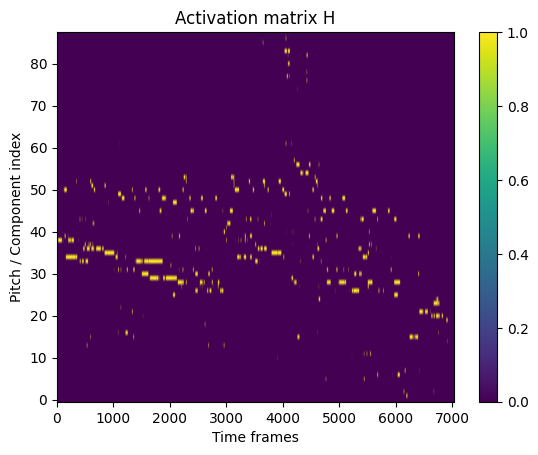

In [23]:
from scipy.ndimage import label
tempo, beats = librosa.beat.beat_track(y=x, sr=f_s)

tempo = float(tempo)          # or: tempo = tempo.item()

print(f"Estimated tempo: {tempo:.2f} BPM")

beat_times = librosa.frames_to_time(beats, sr=f_s)
beat_frames = list(map(int, beat_times * f_s / 1024))
print("beat_frames=",beat_frames)
print(f"Beat positions (sec.): {beat_times}")

def note_tracking(H,th=1.3):
  mean = np.mean(H)
  std = np.std(H)
  thresh = mean + th * std
  H_copy = np.zeros(H.shape)
  for i in range(H.shape[1]):
    indicies = np.where(H[:,i] > thresh)
    H_copy[indicies,i] = 1
  return H_copy

def beat_sync_H(H, beat_frames, mode="mean"):
    Q, T = H.shape
    B = len(beat_frames) - 1
    H_beat = np.zeros((Q, B))

    for b in range(B):
        a, c = beat_frames[b], beat_frames[b+1]
        if mode == "mean":
            H_beat[:, b] = H[:, a:c].mean(axis=1)
        else:
            H_beat[:, b] = H[:, a:c].max(axis=1)

    return H_beat
#CONTINUE HERE
def generate_transcription(H_v,onsets):
  H_r = np.zeros(H_v.shape)
  mask = np.zeros(88)
  for i in range(H_v.shape[1]):
    if(i in onsets):
      H_r[:,i] = H_v[:,i]
      mask = H_v[:,i]
    else:
      H_r[:,i] = H_v[:,i] * mask
  return H_r

def enforce_min_duration(B, min_len=10):
    for q in range(B.shape[0]):
        labels, n = label(B[q])
        for i in range(1, n+1):
            if np.sum(labels == i) < min_len:
                B[q][labels == i] = 0
    return B

H_v = np.log(1+100*H_new)
#print(H_v.shape)
H_v = note_tracking(H_v)
H_v[0,:] = 0 #rough zero-ing A0 is the simplest way to approach NMF artefacts in low pitches
#H_v = np.asarray(H_v)
#H_v = beat_sync_H(H_v,beat_frames)
H_v = enforce_min_duration(H_v)
H_v = generate_transcription(H_v,res)
import matplotlib.pyplot as plt
plt.figure()
#plt.imshow(H_v, aspect='auto', origin='lower')
plt.imshow(H_v, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

In [15]:
print(H_v)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Попробуем готовый NMFD

In [ ]:
from scipy.io import wavfile
import numpy as np
import librosa
from convolutive_MM import convlutive_MM
import torch
from torchnmf.nmf import NMFD
gamma = 1
f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
X = np.abs(librosa.stft(x, n_fft=2048,hop_length=1024))
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
def cnmf(V, n_components=8, n_lags=10, n_iter=100, eps=1e-9):
    """
    V: (F, T) non-negative matrix (e.g. magnitude spectrogram)
    W: (F, K, L)
    H: (K, T)
    """
    F, T = V.shape
    K = n_components
    L = n_lags

    # initialize
    W = np.random.rand(F, K, L)
    H = np.random.rand(K, T)

    for it in range(n_iter):
        print("Iteration number:",it)
        # reconstruct V_hat
        V_hat = np.zeros_like(V)
        for k in range(K):
            for l in range(L):
                V_hat[:, l:] += np.outer(W[:, k, l], H[k, :-l or None])

        # update H
        for k in range(K):
            num = np.zeros(T)
            den = np.zeros(T) + eps
            for l in range(L):
                Wkl = W[:, k, l][:, None]
                num[l:] += (Wkl * V[:, l:]).sum(axis=0)
                den[l:] += (Wkl * V_hat[:, l:]).sum(axis=0)
            H[k] *= num / den

        # update W
        for k in range(K):
            for l in range(L):
                num = (V[:, l:] * H[k, :-l or None]).sum(axis=1)
                den = (V_hat[:, l:] * H[k, :-l or None]).sum(axis=1) + eps
                W[:, k, l] *= num / den

        if it % 10 == 0:
            err = np.linalg.norm(V - V_hat)
            print(f"iter {it:3d} | error {err:.3f}")

    return W, H
#res = cnmf(X,88,10,100,eps=1e-9)
S = torch.from_numpy(X).float().unsqueeze(0)
model = NMFD(S.shape, rank=88, T=10)  # rank = components, T = time lags
model.fit(S, max_iter=200)
# Extract factors
W = model.W.detach().cpu().numpy()  # (F, rank, T)
H = model.H.detach().cpu().numpy()  # (batch, rank, time)

# Remove batch dimension from H
H = H[0]

ModuleNotFoundError: No module named 'convolutive_MM'

In [ ]:
pip install torchnmf

In [ ]:
print(H.shape)
print(H[:,100])

(88, 5418)
[2.83473209e-08 6.50976878e-03 1.41789596e-05 1.52520073e-07
 6.73773190e-11 6.32580509e-03 4.19024815e-07 1.45695822e-07
 5.12761474e-02 5.86620565e-08 2.48410529e-03 1.86016359e-06
 3.35856169e-11 2.82648742e-01 6.40907327e-10 4.86882832e-13
 1.54526517e-01 1.78778432e-02 8.55022892e-02 2.62964522e-06
 1.24121982e-06 3.14110337e-04 2.75774291e-05 2.64729764e-02
 1.51610147e-05 1.17561613e-04 4.98511456e-03 2.54663263e-07
 8.55225977e-03 9.62969295e-08 7.92492528e-07 5.81414402e-01
 1.42720955e-08 7.23814758e-11 1.23293276e-09 3.87781256e-08
 1.10994971e+00 1.21309212e-08 3.84029475e-09 1.08044292e-03
 5.38210334e-05 6.71427081e-10 7.98618771e-07 3.76486016e-04
 3.88029031e-04 3.47614923e-06 4.01852667e-01 3.48497309e-07
 5.86884730e-02 3.26614757e-03 5.65014835e-09 1.82239184e-08
 7.23177118e-09 3.41943360e-06 1.21501932e+01 1.63683857e-20
 1.53367546e-05 1.36501212e-02 1.72257292e-04 5.52130332e-05
 1.34814968e-06 4.82613547e-03 5.68299438e-04 7.87530690e-02
 1.91205490e-

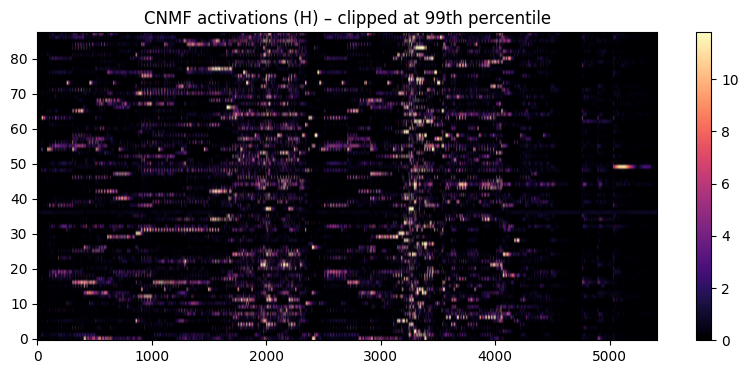

In [ ]:
import matplotlib.pyplot as plt

vmax = np.percentile(H, 99)

plt.figure(figsize=(10,4))
plt.imshow(
    H,
    aspect='auto',
    origin='lower',
    cmap='magma',
    vmin=0,
    vmax=vmax
)
plt.colorbar()
plt.title("CNMF activations (H) – clipped at 99th percentile")
plt.show()

# Пробуем CNMF (имплементация из libnmfd)

In [ ]:
pip install libnmfd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 98.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Обнаружение начал нот (Onsets detection)

Будем использовать подход, называемый Spectral Difference, вычисляя результат по формуле вот отсюда: https://www.iro.umontreal.ca/~pift6080/H09/documents/presentations/xavier_bello_tutorial.pdf

In [ ]:
def H(x):
  return (x+abs(x))/2
def summf(v1,v2):
  #v1 - spectral coefficients vector at moment n
  #v2 - spectral coefficients vector at moment (n+1)
  l = v1.shape[0]
  assert l == v2.shape[0]
  s = 0
  for i in range(l):
    s += (H(v2[i]-v1[i]))**2
  return s
def spec_diff(sp):
  res = []
  for i in range(sp.shape[1]-1):
    res.append(float(summf(sp[:,i],sp[:,i+1])))
  return res
H(5)
def eval_thrshld(d,n,M=100,abs_thrsh=0.1,lam=1.0):
  r = abs_thrsh
  n_s = n-M
  n_f = n+M
  if(n<M):
    n_s = M
  if(n+M>=len(d)):
    n_f = len(d)
  r += lam * np.median(d[n_s:n_f])
  return r
'''def peak_detect(data):
  res = np.zeros((len(data),))
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res[i] = 1
      lval = i
  return res'''
def peak_detect(data):
  #res = np.zeros((len(data),))
  res = []
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res.append(i)
      lval = i
  return res
data = spec_diff(spectrogram_compressed)
res = peak_detect(data)
def sparse_H(H,onsets):
  H_r = H.copy()
  for i in range(H_r.shape[1]):
    if(i in onsets or (i-1) in onsets or (i+1) in onsets):
      H[1::2,i] = 0
    else:
      H[0::2,i] = 0
  return H_r
print(res)
import matplotlib.pyplot as plt



[23, 45, 65, 86, 107, 127, 147, 169, 194, 215, 235, 255, 275, 295, 315, 339, 360, 380, 402]


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import numpy as np
def shift_right(x, k):
    if(k==0):
      return x
    y = np.zeros_like(x)
    y[k:] = x[:-k]
    return y
def note_template(pitch, alpha=0.5):
  r = np.zeros((88,))
  #first eight harmonics of some pitch
  l = [0,12,19,24,28,31,34,36]
  r[l]=1
  #print(pitch)
  r = shift_right(r,pitch)
  return r
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
def rms(x):
    return np.sqrt(np.mean(np.square(x)))
def process_frame(s,k=3,en_thrsh=0.4):
    assert s.shape[0] == 88 and s.shape[1] == 1
    notes = []
    s_c = s.copy()
    s_c = np.asarray(s, dtype=float).squeeze()
    #print(type(s_c))
    #print("s_c=",s_c)
    s_pitches = top_k_indices(s_c,k)
    #print("s_pitches=",s_pitches)
    for l in s_pitches:
      #print(l)
      r = rms(np.dot(note_template(l),s_c))
      #print("r=",r)
      if(r>en_thrsh):
        notes.append(int(l))
    return notes
def note_tracking(mtr):
  r = np.zeros(mtr.shape)
  for i in range(mtr.shape[1]):
    ind = process_frame(mtr[:,i])
    for k in ind:
      r[k,i] = 1
  return r

In [ ]:
def note_tracking_paper_style(H, delta=0.1, win=10):
    Q, T = H.shape
    R = np.zeros_like(H, dtype=np.uint8)

    # 1. Per-pitch normalization (critical)
    '''keepdims=True'''
    Hn = H / (np.max(H, axis=1) + 1e-9)

    for q in range(Q):
        for t in range(T):

            # local mean (zero-padded)
            t0 = max(0, t - win)
            t1 = min(T, t + win + 1)
            local_mean = np.mean(Hn[q, t0:t1])

            # adaptive threshold
            thresh = local_mean + delta

            # onset condition (THIS is what you missed)
            if (
                Hn[q, t] > thresh and
                (t == 0 or Hn[q, t] > Hn[q, t - 1])
            ):
                R[q, t] = 1

    return R
H_n = np.log(1+H_est)
print(H_n.shape)
#H_n = note_tracking(H_n)
print(H_n.shape)
print(H_n[:,100].shape)

plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(note_tracking_paper_style(H_est), aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

(176, 7026)
(176, 7026)
(176, 1)


In [ ]:
def pitch_energy_compensation(H, gamma=0.7):
    """
    H: shape (88, T)
    """
    pitches = np.arange(88)
    weights = 2 ** (gamma * pitches / 12)
    weights = weights / weights.mean()  # normalize

    return H * weights[:, None]
H_n = np.log(1+H_est)
H_n = pitch_energy_compensation(H_n[1::2])
print(H_n.shape)
H_n = note_tracking(H_est)
print(H_n.shape)
print(H_n[:,100].shape)

plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(H_n, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

ValueError: shapes (88,7026) and (88,1) not aligned: 7026 (dim 1) != 88 (dim 0)

In [ ]:
print(H_s.shape)

(88, 418)


In [ ]:
print(note_template(0))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
v=[3,7,5,2,7,8,9,1,2,3,5,6,7,8,9,2,]
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
print(top_k_indices(v, 9))

[14  6  5 13  1  4 12 11  2]


# Оценка результатов транскрибирования

In [ ]:
def evaluate_results(H_et,H):
  #H_et - reference transcription of the piece
  #H - estimated transcription of the piece
  assert H_et.shape == H.shape
  P = 0
  R = 0
  F1 = 0
  TP = 0
  FP = 0
  FN = 0
  for i in range(H_et.shape[1]):
    TP += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 1 and p == 1)
    FP += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 0 and p == 1)
    FN += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 1 and p == 0)
  P = TP / (TP + FP)
  R = TP / (TP + FN)
  F1 = 2 * P * R / (P + R)
  return (P,R,F1)

In [ ]:
a = [0,1,1,1,0]
b = [1,1,1,0,0]
print(sum(1 for t, p in zip(a, b) if t == 1 and p == 1))

2


In [ ]:
print(TP)

0
